# Sarima and Prophet models

add theory and check behaviour...

In [1]:
# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# basic
import os, sys
import warnings

# kats
from kats.consts import TimeSeriesData
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.prophet import ProphetModel, ProphetParams
from kats.utils.backtesters import BackTesterSimple

warnings.simplefilter(action='ignore')
# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

from sscode.data import load_moana_hindcast, Loader


 data not available for the predictor!! 


 loading the Moana v2 hindcast data... 



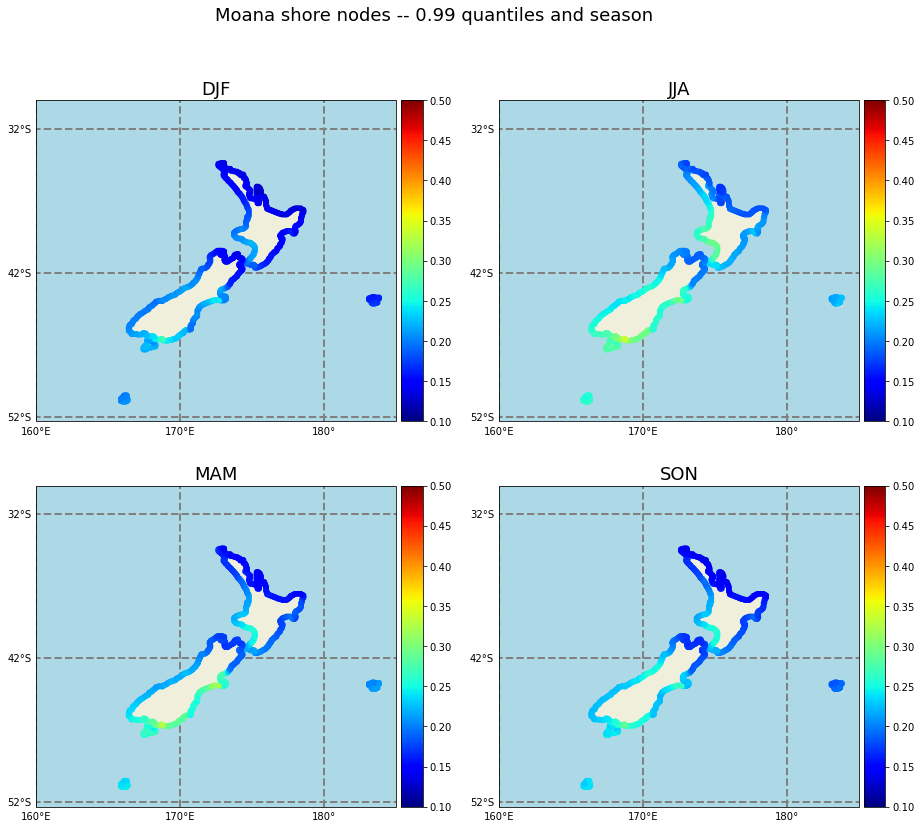


 loading and plotting the UHSLC tidal guages... 



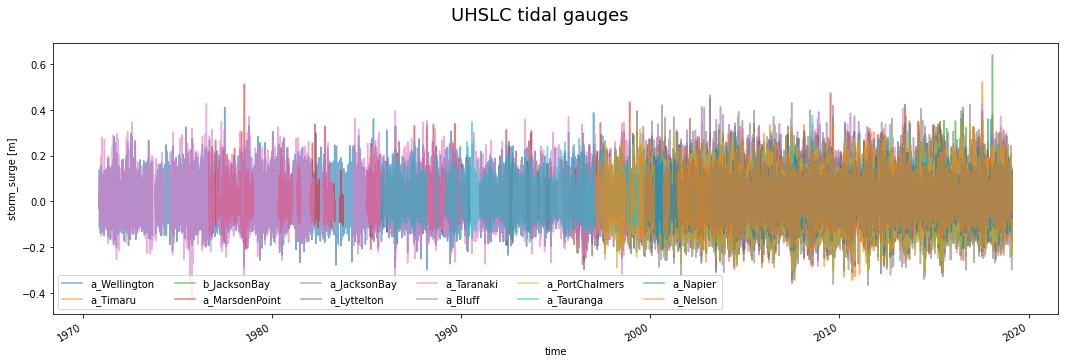

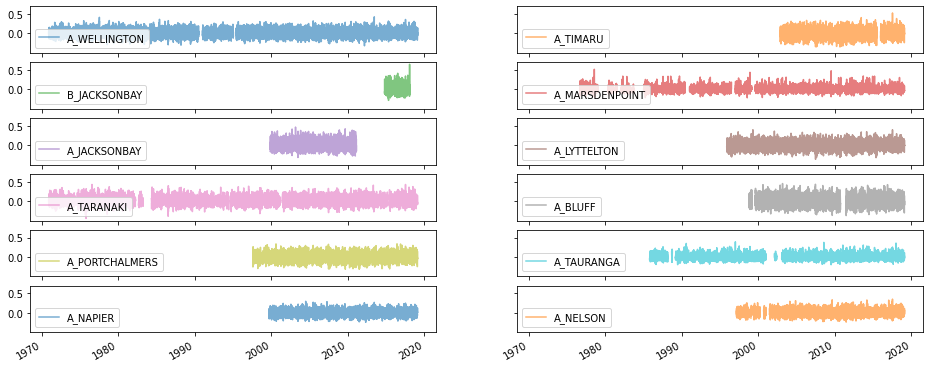

In [2]:
data = Loader(data_to_load=['cfsr_','moana','uhslc'], plot=True)

In [3]:
data.predictand, data.validator

(<xarray.Dataset>
 Dimensions:  (site: 1448, time: 209736)
 Coordinates:
   * site     (site) int64 0 1 2 3 4 5 6 7 ... 1441 1442 1443 1444 1445 1446 1447
   * time     (time) datetime64[ns] 1994-01-17 1994-01-17T01:00:00 ... 2017-12-09
 Data variables:
     elev     (site, time) float32 ...
     lat      (site) float64 -50.96 -50.96 -50.96 -50.96 ... -34.36 -34.36 -34.36
     lon      (site) float64 166.0 166.0 166.1 166.2 ... 172.9 172.9 173.0 173.1
     msea     (site, time) float32 ...
     res      (site, time) float32 ...
     ss       (site, time) float32 nan nan nan nan nan ... nan nan nan nan nan
     tide     (site, time) float32 ...
     trend    (site, time) float32 ...,
 <xarray.Dataset>
 Dimensions:    (name: 12, time: 437507)
 Coordinates:
   * time       (time) datetime64[ns] 1970-01-17 ... 2019-12-15T10:00:00
   * name       (name) <U14 'a_Wellington' 'a_Timaru' ... 'a_Napier' 'a_Nelson'
     latitude   (name) float64 -41.28 -44.38 -43.98 ... -37.65 -39.48 -41.27
     

In [4]:
data_ss = TimeSeriesData(
    data.validator.sel(name='a_Wellington').ss.resample(time='1D').max().\
        dropna(dim='time').to_dataframe()[['ss']].reset_index()
)

In [5]:
data_ss

,time,ss
0,1970-11-13,0.030
1,1970-11-14,0.036
2,1970-11-15,0.004
3,1970-11-16,-0.002
4,1970-11-17,0.048
...,...,...
17127,2019-02-13,0.100
17128,2019-02-14,0.088
17129,2019-02-15,0.074
17130,2019-02-16,-0.008


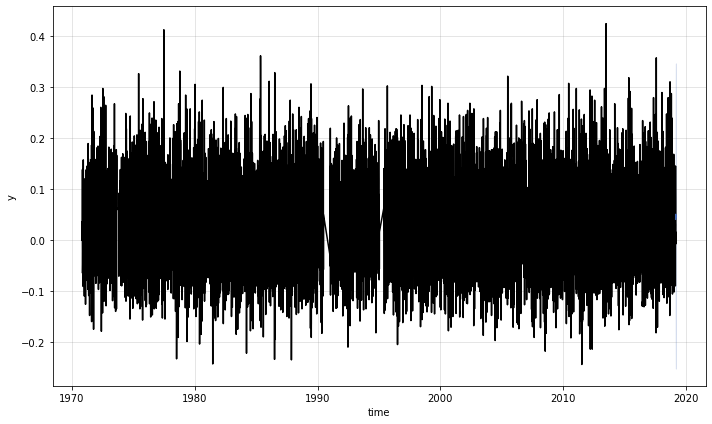

In [6]:
# create SARIMA param class
sarima_params = SARIMAParams(
    p = 2, 
    d = 1, 
    q = 1, 
    trend = 'ct', 
    seasonal_order = (1,0,1,12)
)

# initiate SARIMA model
s = SARIMAModel(data=data_ss, params=sarima_params)

# fit SARIMA model
s.fit()

# generate forecast values
fcst = s.predict(
    steps = 7, 
    freq = '1D'
)

# make plot to visualize
s.plot()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -338.954
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70         19250   9.58564e-05       113.536   7.584e-07       0.001      135  LS failed, Hessian reset 
      95         19250   4.80859e-07       96.8331      0.7196      0.7196      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


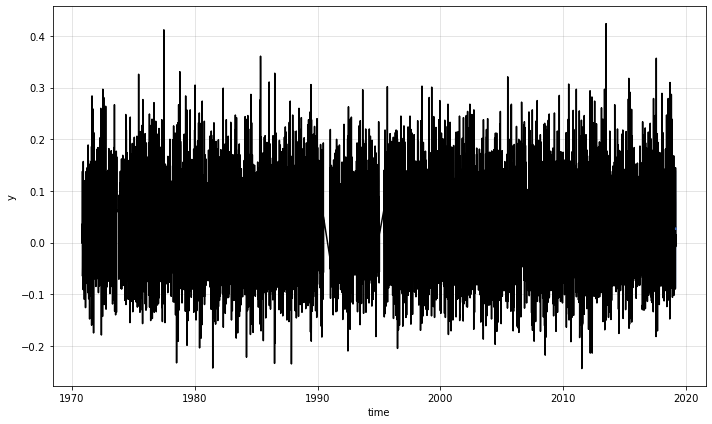

In [7]:
# create a Prophet model param instance
prophet_params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
p = ProphetModel(data_ss, prophet_params)

# fit model simply by calling m.fit()
p.fit()

# make prediction for next 30 month
fcst = p.predict(steps=7, freq='1D')

# plot to visualize
p.plot()

In [8]:
backtester_errors = {}
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

backtester_sarima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=data_ss,
    params=sarima_params,
    train_percentage=75,
    test_percentage=25, 
    model_class=SARIMAModel)

backtester_sarima.run_backtest()

backtester_errors['sarima'] = {}
for error, value in backtester_sarima.errors.items():
    backtester_errors['sarima'][error] = value
    
backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=data_ss,
    params=prophet_params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()

backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -297.699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       14203.2   8.88753e-06       77.3356   1.018e-07       0.001      131  LS failed, Hessian reset 
      99       14203.2   0.000379171       97.7229      0.6436      0.6436      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       14204.3   5.95724e-07       87.0247           1           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [9]:
pd.DataFrame.from_dict(backtester_errors)

,sarima,prophet
mape,inf,inf
smape,-101.366808,0.200139
mae,0.078217,0.068661
mase,1.700160,1.492438
mse,0.009134,0.007428
rmse,0.095574,0.086186
